## ch08 Random Forest
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.24</div>
<div style="text-align: right"> Last update: 2023.7.24</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

### 준비

In [2]:
import subprocess
def my_dot_export(xg, num_trees, filename, title='', direction='TB'):
    """Exports a specified number of trees from an XGBoost model as a graph 
    visualization in dot and png formats.

    Args:
        xg: An XGBoost model.
        num_trees: The number of tree to export.
        filename: The name of the file to save the exported visualization.
        title: The title to display on the graph visualization (optional).
        direction: The direction to lay out the graph, either 'TB' (top to 
            bottom) or 'LR' (left to right) (optional).
    """
    res = xgb.to_graphviz(xg, num_trees=num_trees)
    content = f'''    node [fontname = "Roboto Condensed"];
    edge [fontname = "Roboto Thin"];
    label = "{title}"
    fontname = "Roboto Condensed"
    '''
    out = res.source.replace('graph [ rankdir=TB ]', 
                             f'graph [ rankdir={direction} ];\n {content}')
    # dot -Gdpi=300 -Tpng -ocourseflow.png courseflow.dot 
    dot_filename = filename
    with open(dot_filename, 'w') as fout:
        fout.write(out)
    png_filename = dot_filename.replace('.dot', '.png')
    subprocess.run(f'dot -Gdpi=300 -Tpng -o{png_filename} {dot_filename}'.split())

In [3]:
raw = pd.read_csv("../../data/kaggle-survey-2018/raw.csv")
raw.shape

(23859, 395)

In [4]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.

    This function takes a Pandas DataFrame containing Kaggle 
    survey data as input and returns a new DataFrame. The 
    modifications include extracting and transforming certain 
    columns, renaming columns, and selecting a subset of columns.

    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.

    Returns
    -------
    pd.DataFrame
        The new DataFrame with the modified and selected columns.
    """  
    return (df_
            .assign(age = df_.Q2.str.slice(0, 2).astype(int),
                    education = df_.Q4.replace({
                        'Master’s degree': 18,
                        'Bachelor’s degree': 16,
                        'Doctoral degree': 20,
                        'Some college/university study without earning a bachelor’s degree': 13,
                        'Professional degree': 19,
                        'I prefer not to answer': None,
                        'No formal education past high school': 12}),
                    major = (df_.Q5
                             .pipe(topn, n = 3)
                             .replace({
                                 'Computer science (software engineering, etc.)': 'cs',
                                 'Engineering (non-computer focused)': 'eng',
                                 'Mathematics or statistics': 'stat'})
                             ),
                    years_exp = (df_.Q8.str.replace('+', '', regex=False)
                                 .str.split('-', expand=True)
                                 .iloc[:, 0]
                                 .astype(float)),
                    compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
                           .str.replace('I do not wish to disclose my approximate yearly compensation',
                                        '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)),
                    python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                    r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                    sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
            .rename(columns=lambda col: col.replace(' ', '_'))
            .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
                 'python,r,sql'.split(',')]
            )

In [5]:
def topn(ser, n=5, default='other'):
    """
    Replace all values in a Pandas Series that are not among 
    the top `n` most frequent values with a default value.

    This function takes a Pandas Series and returns a new 
    Series with the values replaced as described above. The 
    top `n` most frequent values are determined using the 
    `value_counts` method of the input Series.

    Parameters
    ----------
    ser : pd.Series
        The input Series.
    n : int, optional
        The number of most frequent values to keep. The 
        default value is 5.
    default : str, optional
        The default value to use for values that are not among 
        the top `n` most frequent values. The default value is 
        'other'.

    Returns
    -------
    pd.Series
        The modified Series with the values replaced.
    """    
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [6]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline

In [7]:
class TweakKagTransformer(base.BaseEstimator,
    base.TransformerMixin):
    """
    A transformer for tweaking Kaggle survey data.

    This transformer takes a Pandas DataFrame containing 
    Kaggle survey data as input and returns a new version of 
    the DataFrame. The modifications include extracting and 
    transforming certain columns, renaming columns, and 
    selecting a subset of columns.

    Parameters
    ----------
    ycol : str, optional
        The name of the column to be used as the target variable. 
        If not specified, the target variable will not be set.

    Attributes
    ----------
    ycol : str
        The name of the column to be used as the target variable.
    """

    def __init__(self, ycol=None):
        self.ycol = ycol

    def transform(self, X):
        return tweak_kag(X)

    def fit(self, X, y=None):
        return self

In [8]:
def get_rawX_y(df, y_col):
    raw = (df
            .query('Q3.isin(["United States of America", "China", "India"]) '
               'and Q6.isin(["Data Scientist", "Software Engineer"])')
          )
    return raw.drop(columns=[y_col]), raw[y_col]

In [9]:
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
                                       variables=['Q1', 'Q3', 'major'])),
     ('num_inpute', imputation.MeanMedianImputer(imputation_method='median',
                                                    variables=['education', 'years_exp']))]
) 

In [10]:
from sklearn import model_selection

In [11]:
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [12]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [13]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)
X_test = kag_pl.transform(kag_X_test)

In [14]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

### 8.1 Ensembles with Bagging

In [15]:
from sklearn import ensemble

In [16]:
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, kag_y_train)
rf.score(X_test, kag_y_test)

0.7237569060773481

In [17]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

개별 트리에 접근하려면 .estimators에 접근하면된다.

In [18]:
rf.estimators_

[DecisionTreeClassifier(max_features='sqrt', random_state=1608637542),
 DecisionTreeClassifier(max_features='sqrt', random_state=1273642419),
 DecisionTreeClassifier(max_features='sqrt', random_state=1935803228),
 DecisionTreeClassifier(max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_features='sqrt', random_state=996406378),
 DecisionTreeClassifier(max_features='sqrt', random_state=1201263687),
 DecisionTreeClassifier(max_features='sqrt', random_state=423734972),
 DecisionTreeClassifier(max_features='sqrt', random_state=415968276),
 DecisionTreeClassifier(max_features='sqrt', random_state=670094950),
 DecisionTreeClassifier(max_features='sqrt', random_state=1914837113),
 DecisionTreeClassifier(max_features='sqrt', random_state=669991378),
 DecisionTreeClassifier(max_features='sqrt', random_state=429389014),
 DecisionTreeClassifier(max_features='sqrt', random_state=249467210),
 DecisionTreeClassifier(max_features='sqrt', random_state=1972458954),
 DecisionTreeC

In [19]:
len(rf.estimators_)

100

In [20]:
print(rf.estimators_[0])

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)


개별 트리를 시각화

In [21]:
from sklearn import tree

[Text(0.5, 0.875, 'Q3_United States of America <= 0.5\ngini = 0.496\nsamples = 1354\nvalue = [1146, 964]\nclass = Data Scientist'),
 Text(0.25, 0.625, 'r <= 0.5\ngini = 0.496\nsamples = 681\nvalue = [496, 588]\nclass = Software Engineer'),
 Text(0.125, 0.375, 'education <= 17.0\ngini = 0.469\nsamples = 530\nvalue = [317, 528]\nclass = Software Engineer'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'education <= 17.0\ngini = 0.376\nsamples = 151\nvalue = [179, 60]\nclass = Data Scientist'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'education <= 17.0\ngini = 0.464\nsamples = 673\nvalue = [650, 376]\nclass = Data Scientist'),
 Text(0.625, 0.375, 'major_cs <= 0.5\ngini = 0.485\nsamples = 176\nvalue = [109, 154]\nclass = Software Engineer'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'major_cs <= 0.5\ngini = 0.413\nsamples = 49

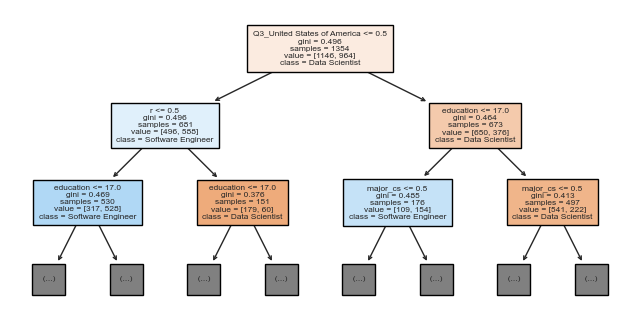

In [22]:
fig, ax = plt.subplots(figsize = (8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(rf.estimators_[0], feature_names=features,
               filled=True, class_names=rf.classes_, ax = ax,
               max_depth=2, fontsize=6
               )

### 8.3 XGBoost Random Forest

xgboost에는 랜덤포레스트 기반 분류기를 제공 : XGBRFClassfier

In [23]:
import xgboost as xgb

In [24]:
rf_xg = xgb.XGBRFClassifier(random_state = 42)
rf_xg.fit(X_train, y_train)
rf_xg.score(X_test, y_test)

0.7447513812154696

In [25]:
rf_xg.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 1.0,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

첫번째 나무를 시각화 해보자.


(process:55840): Pango-WARNING **: 08:39:46.938: couldn't load font "Roboto Condensed Not-Rotated 14", modified variant/weight/stretch as fallback, expect ugly output.


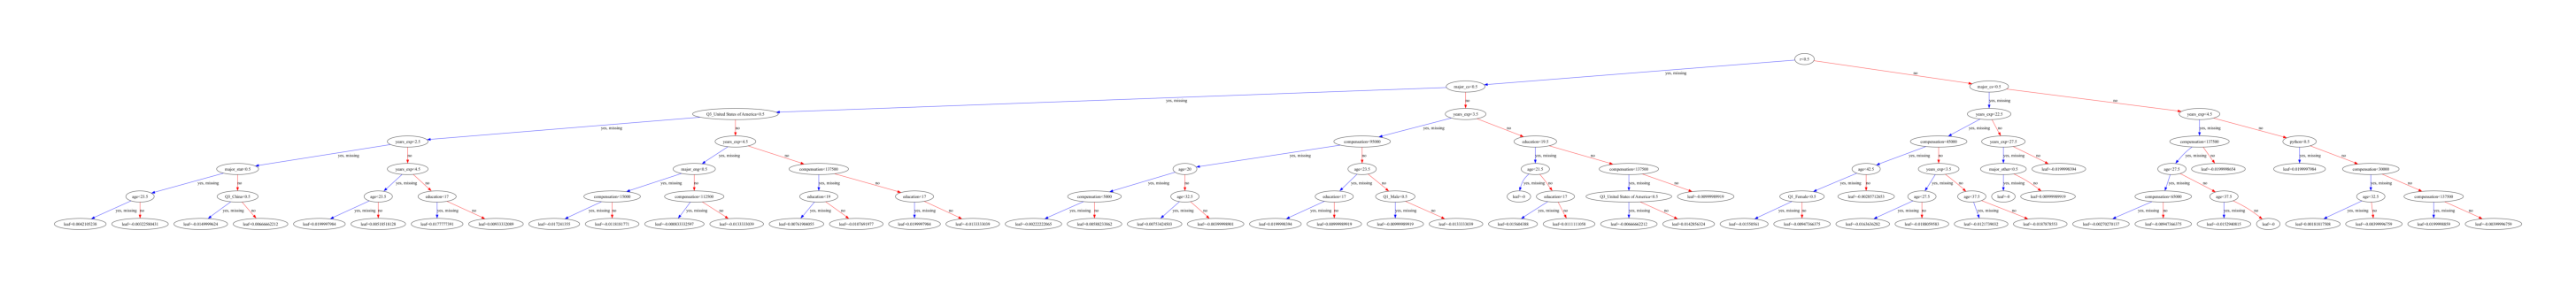

In [26]:
fig, ax = plt.subplots(figsize=(6,12), dpi=600)
xgb.plot_tree(rf_xg, num_trees=0, ax=ax, size='1,1')
my_dot_export(rf_xg, num_trees=0, filename='rf_xg_kag.dot',
title='First Random Forest Tree', direction='LR')

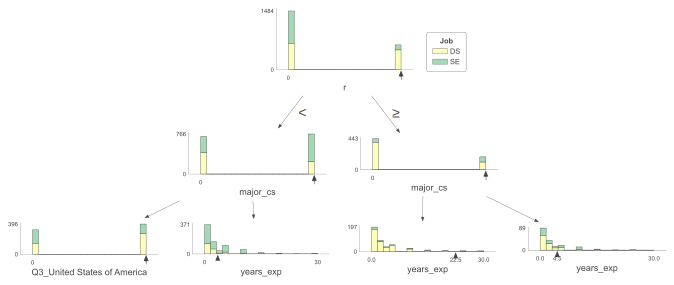

In [27]:
import dtreeviz

viz = dtreeviz.model(rf_xg, X_train=X_train,
y_train=y_train,
target_name='Job', feature_names=list(X_train.columns),
class_names=['DS', 'SE'], tree_index=0)
viz.view(depth_range_to_display=[0,2])

#### 8.4 Random Foreset Hyperparameters

아래는 xgb에 있는 random forest 하이퍼 파라미터 이다.  

하이퍼 파라미터의 종류에는 다음이 있다.  
- tree parameters (like the depth),  
- sampling parameters,  
- the ensembling parameters (number of trees),  
- regularization parameters (like gamma, which prunes back trees to regularize them).

**tree parameters**  

- max_depth=6 - Tree depth. Range [1-large number]  
- max_leaves=0 - Number of leaves in a tree. (Not supported by tree_method='exact'). A
value of 0 means no limit, otherwise, the range is [2-large number]  
- min_child_weight=1 - Minimum sum of hessian (weight) needed in a child. The larger the
value, the more conservative. Range [0,∞]  
- grow_policy="depthwise" - (Only supported with tree_method set to 'hist', 'approx', or
'gpu_hist'. Split nodes closest to root. Set to "lossguide" (with max_depth=0) to mimic
LightGBM behavior.   
- tree_method="auto" - Use "hist" to use histogram bucketing and increase performance.  
    - "auto" heuristic:  
    – 'exact' for small data    
    – 'approx' for larger data
    – 'hist' for histograms (limit bins with max_bins (default 256))

**sampling hyperparameters**  
이것은 누적적으로 동작한다.??먼저 트리에서, 다음은 레벨에서, 마지막으로 노드에서 동작한다.   


- colsample_bytree=1 - Subsample columns at each tree. Range (0,1]  
- colsample_bylevel=1 - Subsample columns at each level (from tree columns colsample_bytree).
Range (0,1]  
-  colsample_bynode=1 - Subsample columns at each node split (from tree columns
colsample_bytree). Range (0,1]  
- subsample=1 - Sample portion of training data (rows) before each boosting round. Range
(0,1]  
- sampling_method='uniform' - Sampling method. 'uniform' for equal probability.
gradient_based sample is proportional to the regularized absolute value of gradients
(only supported by tree_method="gpu_hist".  

**Categorical data hyperparameters**   
이 것을 사용하기 위해서 enable_categorical= True로 설정한다. 그리고 pandas의 컬럼을 카테고리로 설정해야 한다.  (.astype('category')).    


- max_cat_to_onehot=4 - Upper threshold for using one-hot encoding for categorical
features. Use one-hot encoding when the number of categories is less than this number.   

- max_cat_threshold=64 - Maximum number of categories to consider for each split.  

**Ensembling hyperparameters**   

- n_estimators=100 - Number of trees. Range [1, large number]  
- early_stopping_rounds=None - Stop creating new trees if eval_metric score has not  
improved after n rounds. Range [1,∞]  
- eval_metric - Metric for evaluating validation data.  
    – Classification metrics  
        * 'logloss' - Default classification metric. Negative log-likelihood.  
        * 'auc' - Area under the curve of Receiver Operating Characteristic.  
- objective - Learning objective to optimize the fit of the model to data during training.  
    – Classification objectives  
        * 'binary:logistic' - Default classification objective. Outputs probability.  

**Regularization hyperparameters**  

- learning_rate=.3 - After each boosting round, multiply weights to make it more
conservative. Lower is more conservative. Range (0,1]
- gamma=0 - Minimum loss required to make a further partition. Larger is more
conservative. Range [0,∞]
- reg_alpha=0 - L1 regularization. Increasing will make it more conservative.
- reg_lambda=1 - L2 regularization. Increasing will make it more conservative.

**Imbalanced data hyperparameters.**   

- scale_pos_weight=1 - Consider (count negative) / (count positive) for imbalanced classes.
Range (0, large number)
- max_delta_step=0 - Maximum delta step for leaf output. It might help with imbalanced
classes. Range [0,∞]

#### 8.5 Training the Number of Trees in the Forest

모델의 트리수를 변경해가며 학습하고 시각화   

책에는 코드 오류가 있음 : XGBRFClassifier 대신 XGBClassfier 사용

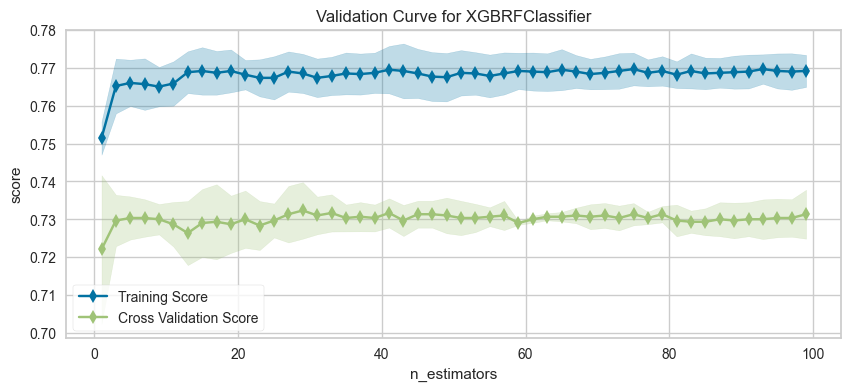

In [28]:
from yellowbrick.model_selection import validation_curve
fig, ax = plt.subplots(figsize=(10,4))
viz = validation_curve(xgb.XGBRFClassifier(random_state=42),
X=pd.concat([X_train, X_test], axis='index'),
y=np.concatenate([y_train, y_test]),
param_name='n_estimators', param_range=range(1, 100, 2),
scoring='accuracy', cv=3,
ax=ax)

- 29개 트리가 성능도 우수하고 효율적인것 같다.

In [29]:
rf_xg29 = xgb.XGBRFClassifier(random_state = 42, n_estimators = 29)
rf_xg29.fit(X_train, y_train)
rf_xg29.score(X_test, y_test)

0.7480662983425415